In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Our goal in this portfolio is taking this data and building a predictive model to classify the books into one of the five target genres.  We will need to extract suitable features from the texts and selecting a suitable model to classify them. we are building two models to compare the results.

## Data Preparation

Our first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [3]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# looking for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# adding this to the book dataframe and then selecting only those rows that have a genre label
# dropping some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape

(8954, 5)

In [4]:
# checking how many books we have in each genre category
genre_books.groupby('genre').count()

,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


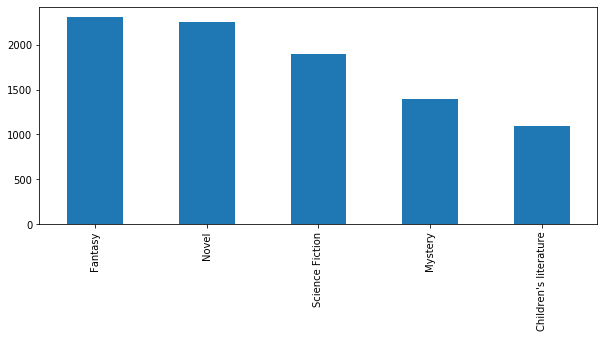

In [5]:
# Plotting in descending manner
plt.figure(figsize=(10,4))
genre_books.genre.value_counts().plot(kind='bar');

In [6]:
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


## Modelling

Before modelling we need to clean the data, it will remove unwanted data and helps to improve the accuracy to our model.

In [7]:
# Cleaning the data
def summary(text):
    # remove backslash 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    return text
genre_books['summary'] = genre_books['summary'].apply(lambda x: summary(x))

In [8]:
# removing stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
genre_books['summary'] = genre_books['summary'].apply(lambda x: remove_stopwords(x))

We need to label the genres to predict, this can be done by using the Multilabelbinarizer which converts the labels into binary.

In [9]:
X = genre_books.summary
y = genre_books.genre
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 6)

The [TFIDF explanation](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Here we are using TFIDF transformer and count vectorizer to find out the importance of a word in the text and it can be used as a weighing factor.

Here we are using Pipeline to combine the classifiers, regressors and other estimators rather than doing it individually. **[Pipeline](https://scikit-learn.org/stable/modules/compose.html)** is a shorthand which is very useful for the whole sequence of estimators.The Pipeline is built using a list of (key, value) pairs, where the key is a string containing the name we want to give this step and value is the estimator object.

We are taking multiple models and comparing the accuracy between models.

KNN algorithm is based on feature similarity. It depends on how close is the sample features to our training set and determines how we can classify a given data point. An object can be classified by a majority vote of its neighbors, with the object being assigned to the class which is  most common among its k nearest neighbors. [KNeighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', KNeighborsClassifier(n_neighbors=12))])
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy KNeighborsClassifier : %.2f\n' % accuracy_score(y_pred, y_test))

Accuracy KNeighborsClassifier : 0.53



The multinomial Naive Bayes normally requires integer feature counts and some fractional counts such as TF-IDF will also work.
The explanation for [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html). It is a supervised learning algorithm based on applying Bayes theorem.

In [11]:
from sklearn.naive_bayes import MultinomialNB

NB = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])
NB.fit(X_train, y_train)

y_pred = NB.predict(X_test)

print('Accuracy MultinomialNB : %.2f\n' %  accuracy_score(y_pred, y_test))

Accuracy MultinomialNB : 0.59



The [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) can be used for classification problems. It is a multinomial logistic regression.

In [12]:
from sklearn.linear_model import LogisticRegression

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression())])
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

print('Training Accuracy Logistic Regression : %.2f\n' % accuracy_train)
print('Testing Accuracy Logistic Regression : %.2f\n' % accuracy_score(y_test, y_pred))

Training Accuracy Logistic Regression : 0.91

Testing Accuracy Logistic Regression : 0.71



In [13]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print('The Confusion matrix on test set is:')
confusion_matrix

The Confusion matrix on test set is:


array([[ 79,  44,   3,  63,   5],
       [ 13, 347,   6,  37,  41],
       [  6,  22, 200,  59,  13],
       [ 19,  27,  17, 356,  41],
       [  8,  44,   6,  52, 283]], dtype=int64)

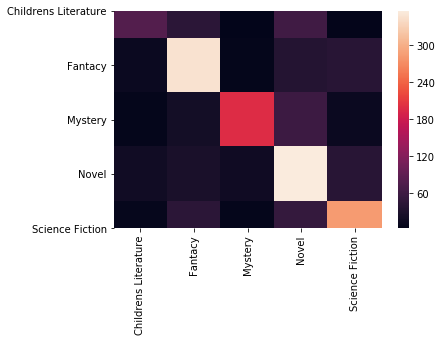

In [14]:
import seaborn as sns
x_axis_labels = ['Childrens Literature', 'Fantacy', 'Mystery', 'Novel', 'Science Fiction'] # labels for x-axis
y_axis_labels = ['Childrens Literature', 'Fantacy', 'Mystery', 'Novel', 'Science Fiction'] # labels for x-axis
sns.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

The Confusion matrix and Heatmap tells us that the predictions for the classes Fantacy and Novel are good then the Science fiction, Mystery and Childrens Literature are misclassified more. The classes having light color are good and the dark colored are giving some errors.

Stochastic Gradient Descent(SGD) is an optimisation method and used to minimize the error and supports different loss functions. It will be useful for lot of machine learning algorithms. For detailed explanation [Stochastic Gradient Descent](https://scikit-learn.org/stable/modules/sgd.html). We got 71 percent accuracy with the SGD classifier.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier())])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('Accuracy SGDClassifier %.2f\n' % accuracy_score(y_pred, y_test))

Accuracy SGDClassifier 0.71



We got the same accuracy for logistic regression and sgd classifier as 71 percent which means the model is good based on the accuracy and we can improve the accuracy by tuning the algorithm and ensembling methods.